In [31]:
import os
import pandas as pd
import librosa
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, lfilter
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [39]:
# --- Fungsi untuk memuat semua file audio dari sebuah folder ---

def load_audio_from_folder(folder_path):
    """
    Fungsi ini membaca setiap file .wav dalam folder yang diberikan,
    mengekstrak sinyal, sampling rate, dan durasi, lalu menyimpannya.
    """
    audio_data = [] # List kosong untuk menampung data dari setiap file

    # Loop melalui setiap file dalam direktori yang ditentukan
    for filename in os.listdir(folder_path):
        # Hanya proses file yang berakhiran .wav
        if filename.endswith('.wav'):
            # Gabungkan path folder dengan nama file untuk mendapatkan path lengkap
            full_path = os.path.join(folder_path, filename)
            try:
                # Muat file audio menggunakan librosa
                # sr=None berarti librosa akan menggunakan sampling rate asli dari file
                signal, sr = librosa.load(full_path, sr=None)
                # Hitung durasi dalam detik
                duration = len(signal) / sr
                # Tambahkan data yang diekstrak ke dalam list 'audio_data'
                audio_data.append({
                    'filename': full_path,
                    'signal': signal,
                    'sampling_rate': sr,
                    'duration': duration
                })
            except Exception as e:
                # Tangani jika ada error saat membaca file
                print(f"Error reading {full_path}: {e}")

    # Kembalikan list yang berisi data dari semua file audio
    return audio_data

# Tentukan path ke folder yang berisi file .wav
folder_path = 'set_b'
# Panggil fungsi untuk memuat data audio
audio_data = load_audio_from_folder(folder_path)
# Ubah list data menjadi DataFrame pandas untuk kemudahan manipulasi
df = pd.DataFrame(audio_data)
# Tampilkan 5 baris pertama dari DataFrame untuk memeriksa hasilnya
df.head()

,filename,signal,sampling_rate,duration
0,set_b\Bunlabelledtest__101_1305030823364_A.wav,"[-0.006225586, -0.0035705566, 0.002746582, -0....",4000,10.59625
1,set_b\Bunlabelledtest__101_1305030823364_D.wav,"[-0.0022277832, -0.0068969727, -0.0046081543, ...",4000,21.77675
2,set_b\Bunlabelledtest__101_1305030823364_F.wav,"[0.013153076, 0.009094238, 0.012359619, 0.0133...",4000,2.66175
3,set_b\Bunlabelledtest__103_1305031931979_A.wav,"[-0.016143799, -0.013641357, -0.012664795, -0....",4000,7.22475
4,set_b\Bunlabelledtest__103_1305031931979_C.wav,"[-0.067352295, -0.056488037, -0.033721924, -0....",4000,8.42900


Preprocessing

In [22]:
# --- Fungsi-fungsi untuk membersihkan dan menyeragamkan sinyal audio ---

def normalize_audio(signal):
    """Menyamakan skala amplitudo sinyal ke rentang [-1, 1]."""
    return signal / np.max(np.abs(signal))

def band_pass_filter(signal, lowcut, highcut, fs, order=5):
    """Menerapkan filter untuk hanya meloloskan frekuensi dalam rentang tertentu."""
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    # Membuat koefisien filter
    b, a = butter(order, [low, high], btype='band')
    # Menerapkan filter ke sinyal
    return lfilter(b, a, signal)

def clip_or_pad(signal, target_samples):
    """Memotong (clip) atau menambah (pad) sinyal agar panjangnya seragam."""
    if len(signal) < target_samples:
        # Jika sinyal lebih pendek, tambahkan nol di akhir (padding)
        signal = np.pad(signal, (0, target_samples - len(signal)), 'constant')
    else:
        # Jika sinyal lebih panjang, potong
        signal = signal[:target_samples]
    return signal

def preprocess(row, target_duration):
    """Menggabungkan semua langkah pra-pemrosesan untuk satu sinyal."""
    signal = row['signal']
    sr = row['sampling_rate']
    # Tentukan panjang target dalam jumlah sampel
    target_samples = int(target_duration * sr)

    # 1. Normalisasi sinyal
    normalized_signal = normalize_audio(signal)

    # 2. Seragamkan panjang sinyal
    processed_signal = clip_or_pad(normalized_signal, target_samples)

    # 3. Terapkan band-pass filter untuk menghilangkan noise
    # Frekuensi 100-1000 Hz dipilih untuk fokus pada frekuensi jantung atau suara relevan lainnya
    filtered_signal = band_pass_filter(processed_signal, lowcut=100, highcut=1000, fs=sr)

    return filtered_signal

# Tentukan durasi target untuk semua sinyal (dalam detik)
target_duration = 6
# Terapkan fungsi 'preprocess' ke setiap baris DataFrame dan simpan hasilnya di kolom baru
df['processed_signal'] = df.apply(lambda row: preprocess(row, target_duration), axis=1)

Visualisasi Hasil Pra-pemrosesan

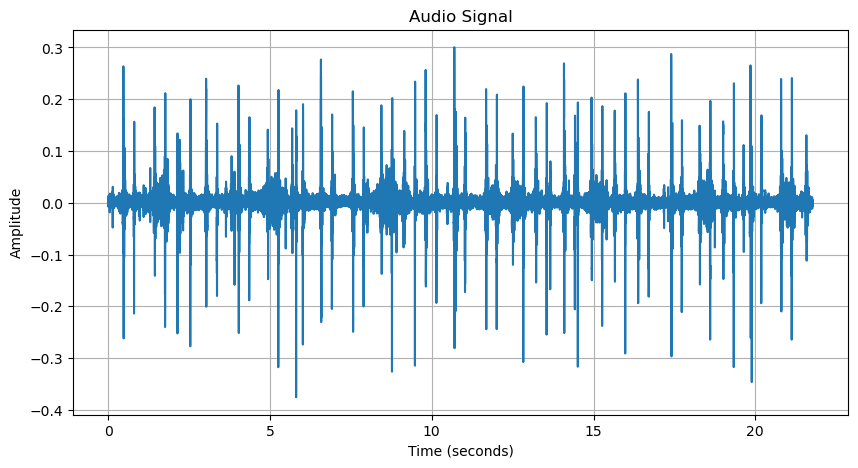

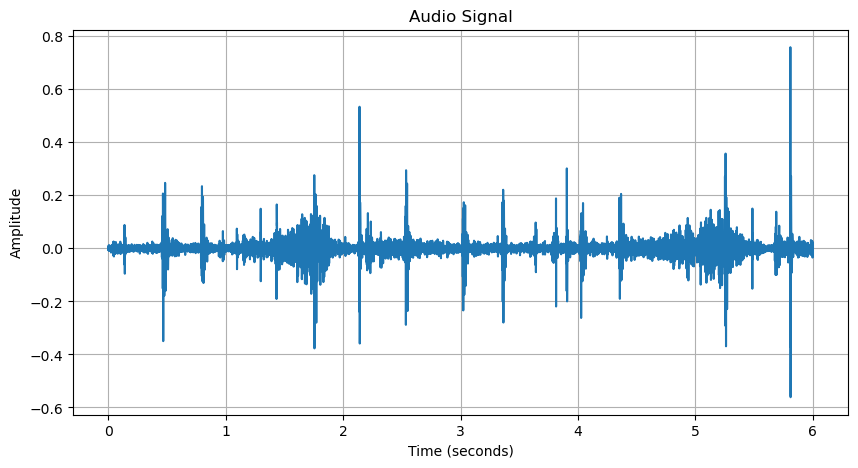

In [23]:
# --- Fungsi untuk memvisualisasikan sinyal audio ---

def plot_signal(signal, fs):
    """Membuat plot grafik dari sinyal audio."""
    # Buat sumbu waktu (x) berdasarkan panjang sinyal dan sampling rate
    time = np.arange(len(signal)) / fs
    # Atur ukuran plot
    plt.figure(figsize=(10, 5))
    # Buat plot garis waktu vs amplitudo
    plt.plot(time, signal)
    plt.title('Audio Signal')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()

# Atur sampling rate (sesuai data)
fs = 4000
# Plot sinyal asli (sebelum pra-pemrosesan) dari data kedua
plot_signal(df['signal'][1], fs)
# Plot sinyal yang sudah diproses dari data kedua
plot_signal(df['processed_signal'][1], fs)

Feature Extraction

In [24]:
# --- Fungsi untuk mengekstrak karakteristik numerik dari sinyal ---

def extract_features(signal, sr):
    """
    Mengekstrak berbagai fitur dari domain waktu dan frekuensi
    untuk merepresentasikan sinyal audio secara numerik.
    """
    # Menghitung rata-rata interval detak (mirip analisis HRV)
    intervals = np.diff(np.where(signal > 0)[0]) / sr
    mean_interval = np.mean(intervals) if len(intervals) > 0 else np.nan

    # Menghitung variabilitas interval (SDNN dan RMSSD)
    sdnn = np.std(intervals) if len(intervals) > 0 else np.nan
    rmssd = np.sqrt(np.mean(np.square(np.diff(intervals)))) if len(intervals) > 1 else np.nan

    # Menghitung FFT untuk menemukan frekuensi dominan (puncak)
    freqs = np.fft.rfftfreq(len(signal), d=1/sr)
    fft_values = np.abs(np.fft.rfft(signal))
    peak_freq = freqs[np.argmax(fft_values)] if len(fft_values) > 0 else np.nan

    # Menghitung energi total sinyal
    energy = np.sum(signal**2)

    # Menghitung MFCC (Mel-Frequency Cepstral Coefficients), fitur penting untuk karakter suara
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfccs, axis=1) # Ambil rata-ratanya

    # Menghitung Zero-Crossing Rate (tingkat perubahan sinyal)
    zero_crossings = librosa.feature.zero_crossing_rate(signal)[0]
    zero_crossing_rate = np.mean(zero_crossings)

    # Menghitung Spectral Centroid (pusat "massa" spektrum, terkait kecerahan suara)
    spectral_centroid = librosa.feature.spectral_centroid(y=signal, sr=sr)[0]
    spectral_centroid_mean = np.mean(spectral_centroid)

    # Menghitung Spectral Bandwidth (lebar spektrum frekuensi)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=signal, sr=sr)[0]
    spectral_bandwidth_mean = np.mean(spectral_bandwidth)

    # Menghitung Chroma (fitur terkait nada musik/harmonik)
    chroma = librosa.feature.chroma_stft(y=signal, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)

    # Menghitung RMS (Root Mean Square) Energy (terkait kenyaringan suara)
    rms = librosa.feature.rms(y=signal)[0]
    rms_mean = np.mean(rms)

    # Kembalikan semua fitur dalam format dictionary
    return {
        'mean_interval': mean_interval, 'sdnn': sdnn, 'rmssd': rmssd,
        'peak_freq': peak_freq, 'energy': energy, 'mfcc_mean': mfcc_mean,
        'zero_crossing_rate': zero_crossing_rate, 'spectral_centroid_mean': spectral_centroid_mean,
        'spectral_bandwidth_mean': spectral_bandwidth_mean, 'chroma_mean': chroma_mean,
        'rms_mean': rms_mean
    }

def process_feature_extract(df):
    """Menerapkan fungsi ekstraksi fitur ke seluruh DataFrame."""
    all_features = []

    # Loop melalui setiap baris di DataFrame input
    for index, row in df.iterrows():
        signal = row['processed_signal']
        sr = row['sampling_rate']

        # Ekstrak fitur dari sinyal yang sudah diproses
        features = extract_features(signal, sr)
        features['filename'] = row['filename'] # Tambahkan nama file untuk referensi

        all_features.append(features)

    # Kembalikan sebagai DataFrame baru
    return pd.DataFrame(all_features)

# Jalankan proses ekstraksi fitur
features_df = process_feature_extract(df)
# Tampilkan 5 baris pertama dari DataFrame fitur
features_df.head()

,mean_interval,sdnn,rmssd,peak_freq,energy,mfcc_mean,zero_crossing_rate,spectral_centroid_mean,spectral_bandwidth_mean,chroma_mean,rms_mean,filename
0,0.000504,0.000628,0.000938,774.666667,60.914845,"[-273.402175097708, 169.34461920311807, -104.2...",0.215041,489.880435,271.148542,"[0.6262953095938945, 0.5553285557519009, 0.519...",0.032467,set_b\Bunlabelledtest__101_1305030823364_A.wav
1,0.000501,0.000757,0.001115,178.333333,35.787597,"[-289.0858593152694, 221.37776341351798, -71.9...",0.136386,319.003493,230.653877,"[0.6884532725194953, 0.6710218608132157, 0.695...",0.035905,set_b\Bunlabelledtest__101_1305030823364_D.wav
2,0.000499,0.000970,0.001410,101.500000,30.709736,"[-478.120618830632, 104.20759914359441, -37.45...",0.062874,210.725933,141.560199,"[0.3270570512247524, 0.34389912732115635, 0.36...",0.023596,set_b\Bunlabelledtest__101_1305030823364_F.wav
3,0.000497,0.000745,0.001104,177.333333,226.937911,"[-193.00065203937513, 235.7933495348705, -90.2...",0.134672,351.648289,235.944417,"[0.6658443325535252, 0.713647591060606, 0.7024...",0.088787,set_b\Bunlabelledtest__103_1305031931979_A.wav
4,0.000506,0.000906,0.001318,105.333333,69.965224,"[-279.51134394449576, 228.87387951523957, -62....",0.111048,260.531396,221.078821,"[0.442348136996964, 0.4953036932972222, 0.5265...",0.053003,set_b\Bunlabelledtest__103_1305031931979_C.wav


Clustering

In [26]:
# --- Mempersiapkan data fitur untuk proses clustering ---

# Fitur seperti MFCC dan Chroma masih dalam bentuk array.
# Kita perlu mengubahnya menjadi kolom-kolom terpisah.
mfcc_df = pd.DataFrame(features_df['mfcc_mean'].tolist(), index=features_df.index).add_prefix('mfcc_')
chroma_df = pd.DataFrame(features_df['chroma_mean'].tolist(), index=features_df.index).add_prefix('chroma_')

# Gabungkan fitur-fitur numerik dengan DataFrame MFCC dan Chroma yang baru
final_features_df = pd.concat([
    features_df.drop(['mfcc_mean', 'chroma_mean', 'filename'], axis=1),
    mfcc_df,
    chroma_df
], axis=1)

# Simpan nama file untuk referensi nanti
filenames = features_df['filename']

# --- Menangani Nilai yang Hilang (Missing Values) ---
# Beberapa fitur mungkin menghasilkan nilai NaN (Not a Number).
# Ganti nilai NaN dengan nilai rata-rata dari kolom masing-masing.
imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(final_features_df)

# --- Penskalaan Fitur (Feature Scaling) ---
# Langkah ini penting agar fitur dengan skala besar tidak mendominasi proses clustering.
# StandardScaler akan mengubah semua fitur agar memiliki rata-rata 0 dan standar deviasi 1.
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_imputed)

print("Bentuk data fitur setelah diproses:", features_scaled.shape)
print("Data siap untuk di-cluster!")

Bentuk data fitur setelah diproses: (656, 34)
Data siap untuk di-cluster!


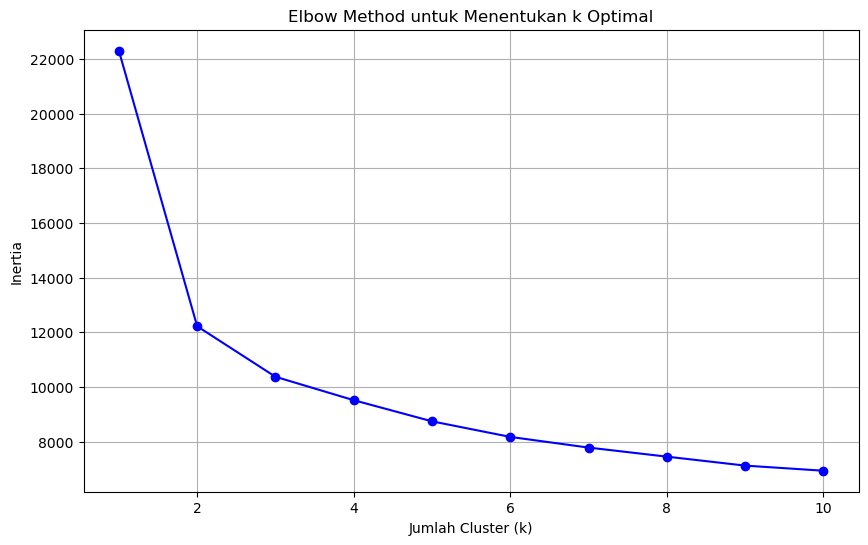

In [27]:
# --- Menentukan Jumlah Cluster Optimal dengan Elbow Method ---

# List untuk menyimpan nilai inertia (ukuran seberapa padat cluster)
inertia = []
# Tentukan rentang jumlah cluster (k) yang akan diuji
K = range(1, 11)

# Loop untuk setiap nilai k
for k in K:
    # Inisialisasi model KMeans dengan jumlah cluster k
    # n_init=10 untuk menjalankan algoritma 10 kali dengan titik awal berbeda
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    # Latih model pada data yang sudah diskalakan
    kmeans.fit(features_scaled)
    # Simpan nilai inertia dari model yang sudah dilatih
    inertia.append(kmeans.inertia_)

# --- Plot Grafik Elbow Method ---
plt.figure(figsize=(10, 6))
# Plot jumlah cluster (K) vs inertia
plt.plot(K, inertia, 'bo-')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method untuk Menentukan k Optimal')
plt.grid(True)
plt.show() # Titik "siku" pada grafik ini menunjukkan k yang paling baik

In [28]:
# --- Menjalankan Clustering dengan K Optimal ---

# Dari grafik elbow, kita pilih k=3 sebagai jumlah cluster yang optimal
optimal_k = 3

# Latih model K-Means final dengan k optimal
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans.fit(features_scaled)

# Dapatkan label cluster (0, 1, atau 2) untuk setiap file audio
cluster_labels = kmeans.labels_

# Tambahkan label cluster ini sebagai kolom baru ke DataFrame asli
df['cluster'] = cluster_labels
features_df['cluster'] = cluster_labels

print(f"Berhasil melakukan clustering menjadi {optimal_k} cluster.")

# Tampilkan jumlah file audio di setiap cluster
print("\nDistribusi file per cluster:")
print(df['cluster'].value_counts())

Berhasil melakukan clustering menjadi 3 cluster.

Distribusi file per cluster:
cluster
0    309
2    185
1    162
Name: count, dtype: int64


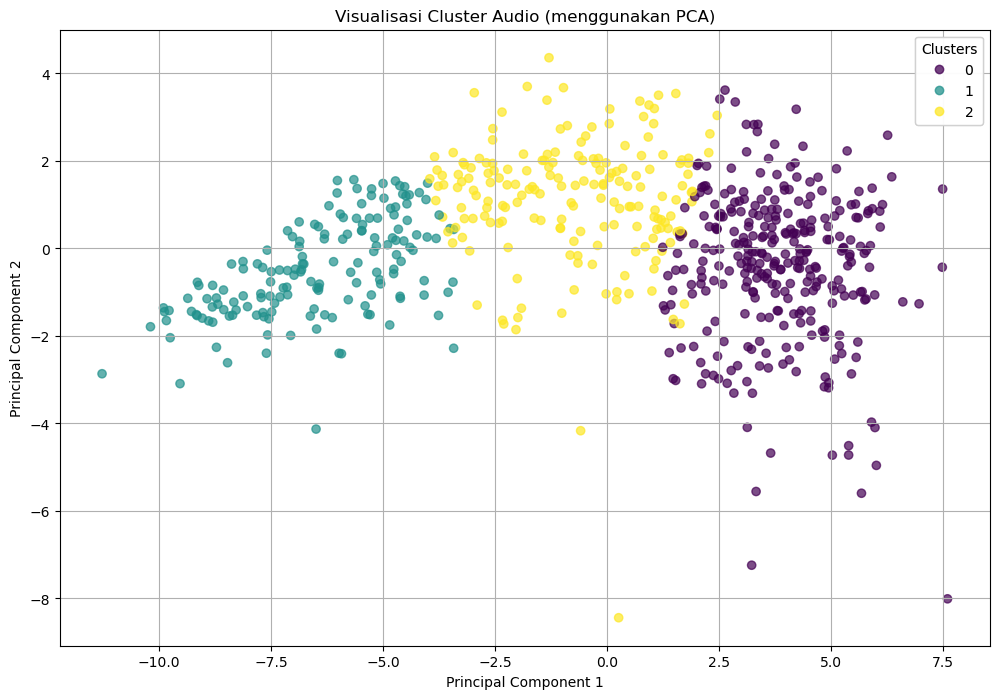

In [29]:
# --- Visualisasi Hasil Clustering menggunakan PCA ---

# Karena kita punya banyak fitur (dimensi), sulit untuk divisualisasikan.
# PCA (Principal Component Analysis) digunakan untuk mengurangi dimensi menjadi 2.
pca = PCA(n_components=2)
# Terapkan PCA pada data fitur yang sudah diskalakan
features_pca = pca.fit_transform(features_scaled)

# Buat scatter plot dari data yang sudah direduksi dimensinya
plt.figure(figsize=(12, 8))
# Sumbu x adalah komponen utama 1, sumbu y adalah komponen utama 2.
# Warna titik (c=cluster_labels) ditentukan oleh label cluster-nya.
scatter = plt.scatter(features_pca[:, 0], features_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)

plt.title('Visualisasi Cluster Audio (menggunakan PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Tambahkan legenda untuk menjelaskan warna cluster
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend1)

plt.grid(True)
plt.show()

In [38]:
score = silhouette_score(features_scaled, cluster_labels)
print(f"\nSilhouette Score for K{'(3)'}: {score:.4f}")


Silhouette Score for K(3): 0.2509
